# Eksperimen 2: OCR Pipeline (PaddleOCR + LLM)

## Objective
Mengimplementasikan pipeline OCR + LLM dengan output terstandar, pengukuran waktu inferensi, dan perhitungan matriks evaluasi (CER).

- **Stage 1 (OCR):** PaddleOCR untuk ekstraksi teks.
- **Stage 2 (LLM):** Ollama (LLaVA) untuk structuring/refining.
- **Metrics:** Inference Time, Character Error Rate (CER).

## Output Format
```python
{
    'time': float,      # Detik
    'text': str,        # Hasil akhir (JSON/Text)
    'image': np.array   # Citra input (optional visualization)
}
```

In [26]:
# Install required packages
%pip install ollama paddleocr opencv-python numpy pandas matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [27]:
import os
import cv2
import time
import numpy as np
import ollama
from paddleocr import PaddleOCR
from pathlib import Path

# --- Utility: Character Error Rate (CER) Calculation ---
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def calculate_cer(reference, hypothesis):
    if not reference:
        return 0.0
    # Remove extra whitespaces for fairer comparison
    ref = " ".join(reference.split())
    hyp = " ".join(hypothesis.split())
    dist = levenshtein_distance(ref, hyp)
    return dist / len(ref)

!pip show paddleocr
### 1. Setup & Initialization

In [28]:
# Init OCR Engine (Load Model)
print("Initializing PaddleOCR...")
# enable_mkldnn=False prevents Windows-specific AVX crashes
ocr = PaddleOCR(lang='en', enable_mkldnn=False, use_angle_cls=True)

# Setup Path
import glob
DATASET_DIR = r'f:/projek dosen/tutoring/Agentic Multimodal Tutor - SLL/dataset/UTS/SOAL2'
IMAGES_DIR = DATASET_DIR
GT_DIR = DATASET_DIR
print(f"Dataset Dir: {DATASET_DIR}")

# --- GROUND TRUTH UTILITY ---
def read_ground_truth(filename_base):
    gt_path = os.path.join(GT_DIR, f"{filename_base}.txt")
    if os.path.exists(gt_path):
        with open(gt_path, 'r', encoding='utf-8') as f:
            return f.read().strip()
    return ""

Initializing PaddleOCR...


C:\Users\User\AppData\Local\Temp\ipykernel_35652\1513193535.py:4: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(lang='en', enable_mkldnn=False, use_angle_cls=True)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\User\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\User\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\User\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To re

Dataset Dir: f:/projek dosen/tutoring/Agentic Multimodal Tutor - SLL/dataset/UTS/SOAL2


**Prompting Technique:**  
Kami menggunakan **Structured Instruction Prompting** (mengadopsi elemen Chain-of-Thought / Task Decomposition). Prompt dirancang dengan memberikan konteks yang jelas, definisi masalah, dan langkah-langkah penyelesaian tugas secara berurutan untuk memandu model memperbaiki typo dan struktur tanpa mengubah logika program.

**Prompt Specs:**
- **Role:** Text Corrector / Coding Assistant.
- **Input:** Raw OCR Text.
- **Output:** Plaintext Pseudocode (No Markdown, algoritma corrected).
- **Strategy:** Step-by-step correction instructions (Fix Typos -> Reformat -> Validate).

In [29]:
# image_files = glob.glob(os.path.join(IMAGES_DIR, "*.jpg")) + glob.glob(os.path.join(IMAGES_DIR, "*.png")) + glob.glob(os.path.join(IMAGES_DIR, "*.jpeg"))

# --- EXPERIMENT 3: Specific File Analysis ---
# Target: if4908_103012500364_nomor2.jpg
target_file_path = os.path.join(IMAGES_DIR, 'if4908_103012500364_nomor2.jpg')
if os.path.exists(target_file_path):
    image_files = [target_file_path]
else:
    print(f'Warning: Specific file not found at {target_file_path}')
    image_files = []

print(f"Found {len(image_files)} images.")

results = []

# Ensure OCR is initialized correctly
if 'ocr' not in locals():
    ocr = PaddleOCR(lang='en', enable_mkldnn=False, use_angle_cls=True)

for image_path in image_files:
    filename = os.path.basename(image_path)
    filename_base = os.path.splitext(filename)[0]
    ground_truth_text = read_ground_truth(filename_base)
    print(f"\nProcessing: {filename}...")
    
    start_time = time.time()
    
# --- STAGE 1: OCR ---
# Use predict() as ocr() is deprecated and fails with cls arg
ocr_result = ocr.predict(image_path)
extracted_lines = []
bboxes = []

if ocr_result and len(ocr_result) > 0:
    if isinstance(ocr_result[0], dict) and "rec_texts" in ocr_result[0]:
        extracted_lines = ocr_result[0].get("rec_texts", [])
        # Handle bbox extraction if available in this format (dt_polys)
        if "dt_polys" in ocr_result[0]:
            bboxes = ocr_result[0]["dt_polys"]
            
    elif isinstance(ocr_result[0], list):
        # Standard [[[[x,y],..], (text, conf)], ...]
        # Or simplified
        for line in ocr_result[0]:
            if isinstance(line, list) and len(line) >= 2:
                # BBox is usually index 0, text info index 1
                if isinstance(line[0], list): # Polygon points
                    bboxes.append(line[0])
                
                if isinstance(line[1], tuple) or isinstance(line[1], list):
                    extracted_lines.append(line[1][0])

raw_text = "\n".join(extracted_lines)

# --- Visualization & Saving ---
if bboxes:
    # Visualize BBoxes
    import cv2
    import matplotlib.pyplot as plt
    
    img_vis = cv2.imread(image_path)
    img_vis = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)
    
    for box in bboxes:
        box = np.array(box).astype(np.int32).reshape((-1, 1, 2))
        cv2.polylines(img_vis, [box], True, (255, 0, 0), 2)
    
    # Save visualization
    vis_filename = f"vis_{filename}"
    vis_path = os.path.join(r'results/bbox', vis_filename)
    # Convert back to BGR for opencv saving if using cv2.imwrite, or just use plt
    # Let's use plt to save as is simpler with established RGB
    plt.figure(figsize=(10, 10))
    plt.imshow(img_vis)
    plt.axis('off')
    plt.savefig(vis_path, bbox_inches='tight')
    plt.close()
    print(f"  Saved bbox visualization to {vis_path}")
    
    # Save bbox coordinates txt
    bbox_txt_path = os.path.join(r'results/bbox', f"bbox_{filename_base}.txt")
    with open(bbox_txt_path, 'w', encoding='utf-8') as f:
        for i, box in enumerate(bboxes):
            text = extracted_lines[i] if i < len(extracted_lines) else ""
            f.write(f"{box} | {text}\n")
    # --- STAGE 2: LLM ---
    final_text_output = ""
    if raw_text.strip():
        # Load prompt correction
        try:
            with open('prompt_correction.txt', 'r', encoding='utf-8') as f:
                prompt_template = f.read()
            prompt_content = prompt_template.replace("{OCR_TEXT}", raw_text)
        except Exception as e:
            print(f"Error loading prompt: {e}")
            prompt_content = f"Correct this OCR text:\n{raw_text}"
        try:
            response = ollama.chat(
                model='llava',
                messages=[{'role': 'user', 'content': prompt_content}]
            )
            # FIX: Properly extract content from response object
            if isinstance(response, dict) and 'message' in response:
                final_text_output = response['message']['content']
            elif hasattr(response, 'message') and hasattr(response.message, 'content'):
                final_text_output = response.message.content
            else:
                # Fallback clean up if it's a raw string representation
                import re
                str_resp = str(response)
                match = re.search(r"content='(.*?)'", str_resp, re.DOTALL)
                if match:
                    final_text_output = match.group(1).replace("\\n", "\n")
                else:
                    final_text_output = str_resp # Last resort
            
            # Clean up markdown code blocks if present
            final_text_output = final_text_output.replace("```plaintext", "").replace("```", "").strip()
            
        except Exception as e:
             print(f"LLM Error: {e}")
             final_text_output = raw_text # Fallback to raw text if LLM fails
    
    end_time = time.time()
    inference_time = end_time - start_time
    
    # Calculate CER for both stages
    cer_raw = calculate_cer(ground_truth_text, raw_text)
    cer_refined = calculate_cer(ground_truth_text, final_text_output)
    
    print(f"  OCR Length: {len(raw_text)} chars | CER Raw: {cer_raw:.2%} | CER Refined: {cer_refined:.2%} | Time: {inference_time:.2f}s")
    
    results.append({
        'filename': filename,
        'time': inference_time,
        'cer_raw': cer_raw,
        'cer_refined': cer_refined,
        'raw_text': raw_text,
        'final_text': final_text_output,
        'ground_truth': ground_truth_text
    })

Found 1 images.

Processing: if4908_103012500364_nomor2.jpg...
  Saved bbox visualization to results/bbox\vis_if4908_103012500364_nomor2.jpg
  OCR Length: 206 chars | CER Raw: 47.06% | CER Refined: 47.79% | Time: 79.95s


### 3. Output & Evaluation

Note: you may need to restart the kernel to use updated packages.

=== SUMMARY ===
Average Time: 79.9478s
Average CER (Raw): 47.06%
Average CER (Refined): 47.79%

Detailed Results exported to 'exp2_results.csv'
Graph saved to results/cer_comparison.png


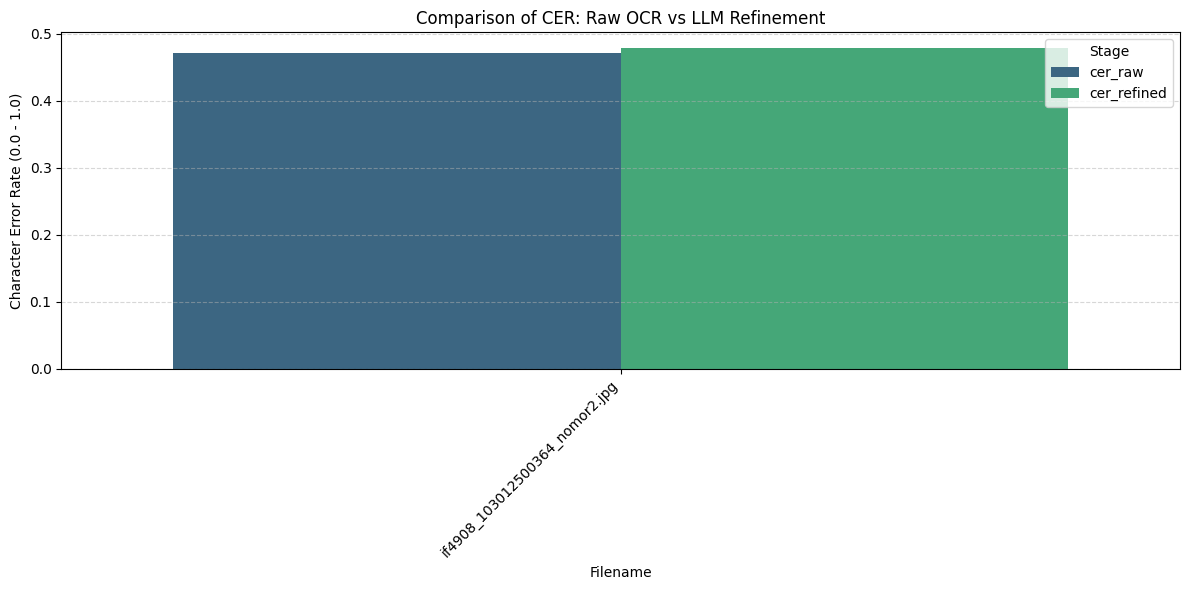

In [30]:
%pip install matplotlib seaborn
print("\n=== SUMMARY ===")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(results)
if not df.empty:
    print(f"Average Time: {df['time'].mean():.4f}s")
    print(f"Average CER (Raw): {df['cer_raw'].mean():.2%}")
    print(f"Average CER (Refined): {df['cer_refined'].mean():.2%}")
    print("\nDetailed Results exported to 'exp2_results.csv'")
    df.to_csv('results/exp3_results.csv', index=False)
    
    # --- Visualization ---
    try:
        plt.figure(figsize=(12, 6))
        df_melted = df.melt(id_vars=['filename'], value_vars=['cer_raw', 'cer_refined'], var_name='Stage', value_name='CER')
        
        sns.barplot(data=df_melted, x='filename', y='CER', hue='Stage', palette='viridis')
        plt.title('Comparison of CER: Raw OCR vs LLM Refinement')
        plt.xlabel('Filename')
        plt.ylabel('Character Error Rate (0.0 - 1.0)')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        
        # Save the plot
        save_path = 'results/cer_comparison.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Graph saved to {save_path}")
        
        plt.show()
    except Exception as e:
        print(f"Error plotting graph: {e}")
else:
    print("No results to show.")